In [1]:
from typing import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
# from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers

# Import state tomography modules
from qiskit_experiments.library import StateTomography
from osp_solutions.patch_ignis import rename_qcs_StateTomography_to_ignis
from osp_solutions.tomography import StateTomographyFitter
from qiskit.quantum_info import state_fidelity

from osp_solutions.circuits import append_block_trotter, append_block_trotter_proposed, append_initial_state, append_block_trotter_aj, append_block_trotter_negishi
from osp_solutions.simulator_dm import make_dm_binary, hamiltonian_to_dm, DMExtended
from osp_solutions.hamiltonian import Hamiltonian, make_H_Heisenberg
from osp_solutions.backend_simulator import result_to_dms

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
# from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
# backend = AerSimulator.from_backend(FakeJakartaV2())
# backend = Aer.get_backend("qasm_simulator")

simulator_ideal = AerSimulator(method="density_matrix")

from qiskit.circuit import QuantumCircuit, Instruction, Parameter # , QuantumRegister

In [2]:
def gate_U_negishi(dt, 
                   option: str = "a",
                   to_instruction: bool = True,
                   add_barrier: bool = False,
                  ) -> Union[QuantumCircuit, Instruction]:
    """
    dt: qiskit._accelerate.circuit.Parameter
    Create and return the circuit instruction of the one trotter step with rotation angle `dt`.
    """

    theta = np.pi / 2 - 2 * dt
    phi = - theta

    theta_negative_t = np.pi / 2 + 2 * dt
    phi_negative_t = - theta_negative_t
    
    qc = QuantumCircuit(2)

    if option == "a":
        qc.cx(0, 1)

        qc.rz(- np.pi / 2, 0)
        qc.ry(- phi, 0)
        qc.rz(- theta, 1)

        qc.cx(1, 0)

        qc.ry(- theta, 0)
        
        qc.cx(0, 1)

        qc.rz(np.pi / 2, 1)

    elif option == "b":
        qc.cx(1, 0)

        qc.rz(- np.pi / 2, 1)
        qc.ry(- phi, 1)
        qc.rz(- theta, 0)

        qc.cx(0, 1)

        qc.ry(- theta, 1)
        
        qc.cx(1, 0)

        qc.rz(np.pi / 2, 0)

    elif option == "c":
        qc.rz(- np.pi / 2, 1)

        qc.cx(0, 1)

        qc.ry(theta_negative_t, 0)

        qc.cx(1, 0)

        qc.rz(theta_negative_t, 1)
        qc.ry(phi_negative_t, 0)
        qc.rz(np.pi / 2, 0)

        qc.cx(0, 1)
        
    else:
        raise Exception
    
    if add_barrier:
        qc.barrier()

    return qc.to_instruction(label="Trotter") if to_instruction else qc

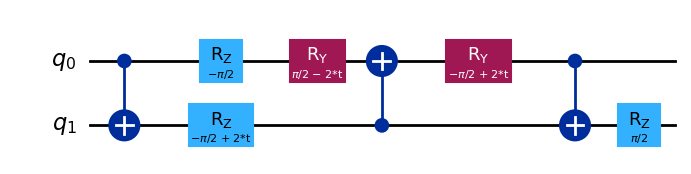

In [3]:
qc = gate_U_negishi(dt=Parameter("t"), 
                    option = "a",
                    to_instruction = False,
                    add_barrier = False,
                   )
qc.draw("mpl")

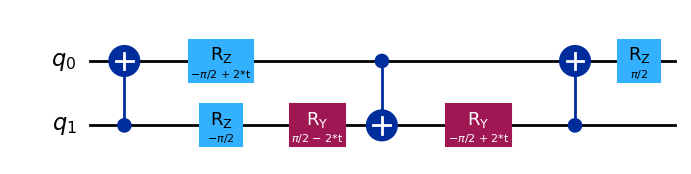

In [4]:
qc = gate_U_negishi(dt=Parameter("t"), 
                    option = "b",
                    to_instruction = False,
                    add_barrier = False,
                   )
qc.draw("mpl")

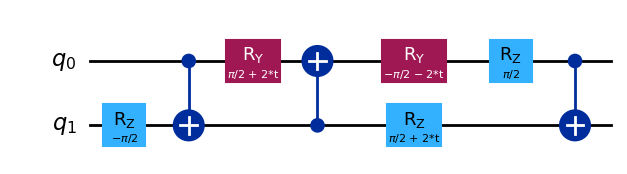

In [5]:
qc = gate_U_negishi(dt=Parameter("t"), 
                    option = "c",
                    to_instruction = False,
                    add_barrier = False,
                   )
qc.draw("mpl")

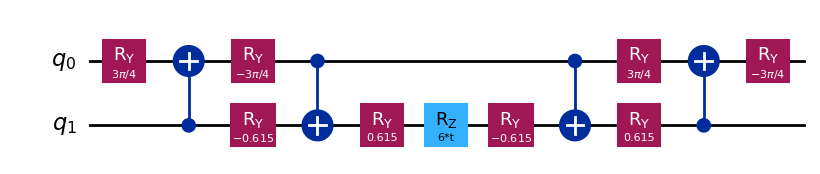

In [ ]:
theta = np.arctan(1 / np.sqrt(2))
t = Parameter("t")

qc = QuantumCircuit(2)

qc.ry(3 * np.pi / 4, 0)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(theta, 1)
qc.rz(6 * t, 1)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(3 * np.pi / 4, 0)
qc.ry(theta, 1)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)

qc.draw("mpl")

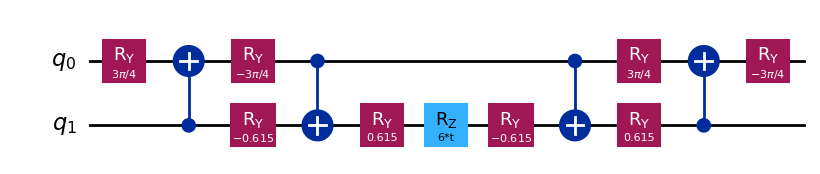

In [11]:
theta = np.arctan(1 / np.sqrt(2))
t = Parameter("t")

qc = QuantumCircuit(2)

qc.ry(3 * np.pi / 4, 0)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(theta, 1)
qc.rz(6 * t, 1)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(3 * np.pi / 4, 0)
qc.ry(theta, 1)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)

qc_t3 = transpile(qc, optimization_level=3)
qc_t3.draw("mpl")

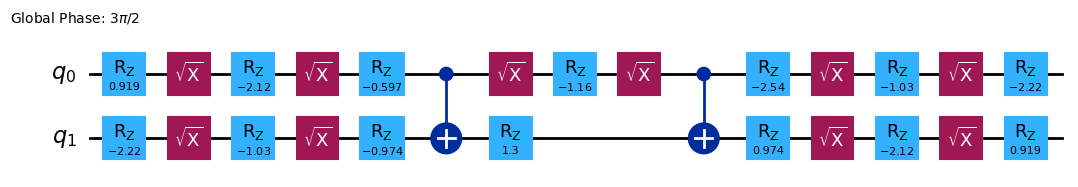

In [14]:
theta = np.arctan(1 / np.sqrt(2))
t = Parameter("t")

qc = QuantumCircuit(2)

qc.ry(3 * np.pi / 4, 0)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(theta, 1)
qc.rz(6 * t, 1)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(3 * np.pi / 4, 0)
qc.ry(theta, 1)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)

qc = qc.assign_parameters({t: 1 / 2})
qc_t3 = transpile(qc, 
                  optimization_level=3, 
                  basis_gates=["rz", "sx", "cx"],
                 )
qc_t3.draw("mpl")

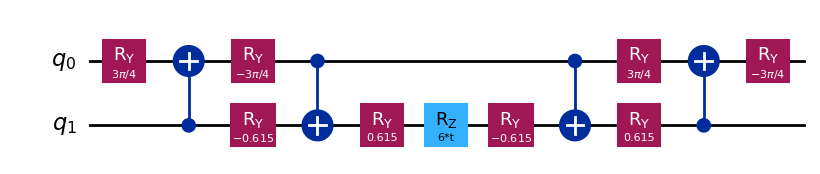

In [ ]:
theta = np.arctan(1 / np.sqrt(2))

t = Parameter("t")

qc = QuantumCircuit(2)

qc.ry(3 * np.pi / 4, 0)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(theta, 1)
qc.rz(6 * t, 1)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(3 * np.pi / 4, 0)
qc.ry(theta, 1)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)

qc.draw("mpl")

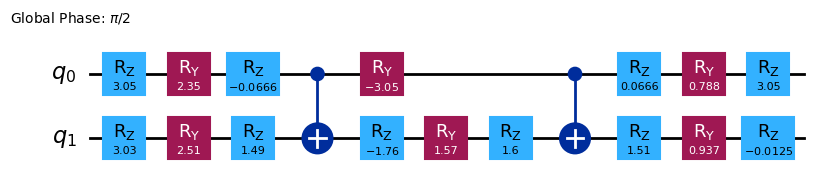

In [36]:
qc_t = qc.assign_parameters({t: 1})
qc_t3 = transpile(qc_t, 
                  optimization_level=3, 
                  basis_gates=["rz", "ry", "cx"],
                 )
qc_t3.draw("mpl")

In [37]:
from qiskit.quantum_info import Operator

U_qc_t = Operator(qc_t).data     # numpy.ndarray (4x4)
print(U_qc_t)

U_qc_t3 = Operator(qc_t3).data     # numpy.ndarray (4x4)
print(U_qc_t3)

np.allclose(U_qc_t, U_qc_t3)

[[-9.89992497e-01-1.41120008e-01j  0.00000000e+00+6.93889390e-18j
  -4.68860061e-17-6.93889390e-18j  1.06215989e-17+0.00000000e+00j]
 [ 0.00000000e+00-6.93889390e-18j -9.89992497e-01+4.70400027e-02j
   4.06640175e-17-9.40800054e-02j -2.56428082e-17-9.40800054e-02j]
 [ 0.00000000e+00+1.60267551e-18j  0.00000000e+00-9.40800054e-02j
  -9.89992497e-01+4.70400027e-02j  5.55111512e-17-9.40800054e-02j]
 [ 0.00000000e+00+6.63849934e-19j  0.00000000e+00-9.40800054e-02j
  -5.55111512e-17-9.40800054e-02j -9.89992497e-01+4.70400027e-02j]]
[[-9.89992497e-01-1.41120008e-01j  2.04837032e-16-8.03642464e-16j
   1.11128945e-16-1.66503957e-17j  2.23445574e-16+1.74877573e-16j]
 [-3.48563965e-16-9.36913320e-16j -9.89992497e-01+4.70400027e-02j
   6.89488561e-16-9.40800054e-02j  8.26095376e-16-9.40800054e-02j]
 [-1.66486645e-16+7.98350387e-18j -3.24011209e-16-9.40800054e-02j
  -9.89992497e-01+4.70400027e-02j -4.34814561e-16-9.40800054e-02j]
 [-1.99058996e-16+1.25344908e-16j -2.70994788e-16-9.40800054e-02j
  

True

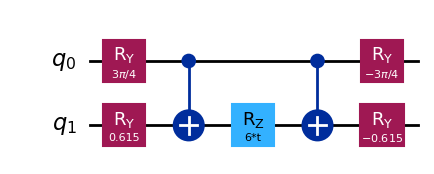

In [29]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

theta = np.arctan(1/np.sqrt(2))
t = Parameter('t')

qc_min = QuantumCircuit(2)
qc_min.ry(3*np.pi/4, 0)
qc_min.ry(theta, 1)

qc_min.cx(0, 1)
qc_min.rz(6*t, 1)
qc_min.cx(0, 1)

qc_min.ry(-theta, 1)
qc_min.ry(-3*np.pi/4, 0)

qc_min.draw("mpl")

In [43]:
t_to_assign = 2.345
qc_t = qc.assign_parameters({t: t_to_assign})

### proposed
U_qc_t = Operator(qc_t).data     # numpy.ndarray (4x4)
print(U_qc_t)

### optimised 
qc_t3 = transpile(qc_t, 
                  optimization_level=3, 
                  basis_gates=["rz", "ry", "cx"],
                 )
U_qc_t3 = Operator(qc_t3).data     # numpy.ndarray (4x4)
print(U_qc_t3)

### chatgpt
qc_min_t = qc.assign_parameters({t: t_to_assign})

U_min_t = Operator(qc_min_t).data     # numpy.ndarray (4x4)
print(U_min_t)

print(np.allclose(U_qc_t, U_qc_t3))
print(np.allclose(U_qc_t3, U_min_t))
print(np.allclose(U_min_t, U_qc_t))

[[ 7.30450700e-01-6.82965427e-01j  0.00000000e+00+0.00000000e+00j
  -1.06215989e-17+2.77555756e-17j  4.59748170e-17+2.77555756e-17j]
 [-5.55111512e-17+2.77555756e-17j  7.30450700e-01+2.27655142e-01j
   2.56428082e-17-4.55310285e-01j  3.40646020e-17-4.55310285e-01j]
 [ 0.00000000e+00+0.00000000e+00j -4.59748170e-17-4.55310285e-01j
   7.30450700e-01+2.27655142e-01j -5.55111512e-17-4.55310285e-01j]
 [ 0.00000000e+00+0.00000000e+00j -3.40646020e-17-4.55310285e-01j
   0.00000000e+00-4.55310285e-01j  7.30450700e-01+2.27655142e-01j]]
[[ 7.30450700e-01-6.82965427e-01j  1.18218529e-16+1.71974482e-16j
   8.99049946e-16-2.23821740e-16j -4.33245945e-16+1.75149486e-16j]
 [ 1.32237632e-17+2.82970950e-16j  7.30450700e-01+2.27655142e-01j
   5.21357945e-16-4.55310285e-01j  2.43317190e-16-4.55310285e-01j]
 [-6.45167497e-16-1.37909640e-16j  1.18956440e-15-4.55310285e-01j
   7.30450700e-01+2.27655142e-01j  4.81312224e-16-4.55310285e-01j]
 [ 6.45116344e-16+3.88383951e-16j  1.21782979e-15-4.55310285e-01j
  

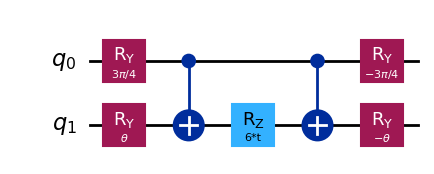

In [ ]:
# theta = np.arctan(1/np.sqrt(2))
t = Parameter('t')
theta = Parameter(r"$\theta$")

qc_min = QuantumCircuit(2)
qc_min.ry(3*np.pi/4, 0)
qc_min.ry(theta, 1)

qc_min.cx(0, 1)
qc_min.rz(6*t, 1)
qc_min.cx(0, 1)

qc_min.ry(-theta, 1)
qc_min.ry(-3*np.pi/4, 0)

qc_min.draw("mpl")

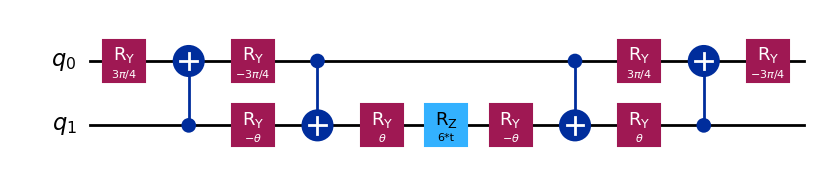

In [45]:
t = Parameter("t")

theta = Parameter(r"$\theta$")

qc = QuantumCircuit(2)

qc.ry(3 * np.pi / 4, 0)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(theta, 1)
qc.rz(6 * t, 1)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(3 * np.pi / 4, 0)
qc.ry(theta, 1)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)

qc.draw("mpl")

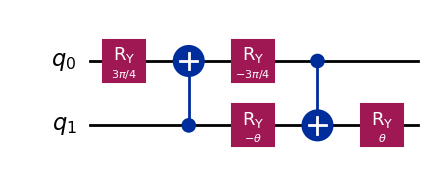

In [46]:
theta = Parameter(r"$\theta$")

qc = QuantumCircuit(2)

qc.ry(3 * np.pi / 4, 0)

qc.cx(1, 0)

qc.ry(- 3 * np.pi / 4, 0)
qc.ry(- theta, 1)

qc.cx(0, 1)

qc.ry(theta, 1)

qc.draw("mpl")

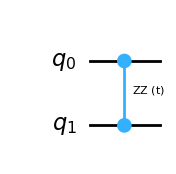

In [48]:
t = Parameter('t')
theta = Parameter(r"$\theta$")

qc_rzz = QuantumCircuit(2)

qc_rzz.rzz(t, 0, 1)

qc_rzz.draw("mpl")

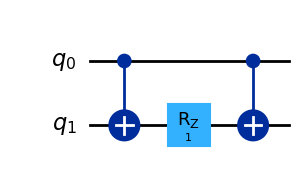

In [50]:
qc_rzz_t = qc_rzz.assign_parameters({t: 1})
qc_rzz_t3 = transpile(qc_rzz_t, 
                  optimization_level=3, 
                  basis_gates=["rz", "ry", "cx"],
                 )
qc_rzz_t3.draw("mpl")